In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df=pd.read_csv('../datasets/data_banknote_authentication.txt',header=None, names=column_names)


In [13]:
# Split the data into features and labels
X = df.drop('class', axis=1)
y = df['class']


# Initialize the scaler
scaler = StandardScaler()
# Fit the scaler to the features and transform
X_scaled = scaler.fit_transform(X)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [14]:
# Initialize the logistic regression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Calculate the logistic loss (log loss)
logistic_loss = log_loss(y_test, y_pred_prob)
logistic_loss


0.057399612133604755

In [15]:
# Create a logistic regression base estimator
log_reg_base = LogisticRegression()

# Initialize the AdaBoostClassifier with logistic regression as the base estimator
ada_boost = AdaBoostClassifier(base_estimator=log_reg_base, n_estimators=50, random_state=42)

# Fit the AdaBoost model to the training data
ada_boost.fit(X_train, y_train)

# Predict class labels on the test set
y_pred_ada = ada_boost.predict(X_test)

# Predict class probabilities on the test set
y_pred_prob_ada = ada_boost.predict_proba(X_test)[:, 1]

# Calculate the binary crossentropy (log loss)
adaboost_loss = log_loss(y_test, y_pred_prob_ada)

# We can also check the accuracy of the model
accuracy_ada = accuracy_score(y_test, y_pred_ada)

adaboost_loss, accuracy_ada


/Users/nazarii_mozol/projects/studing/Machine-Learning/osx-venv-3_12/lib/python3.12/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.6348283980365846, 0.9781818181818182)

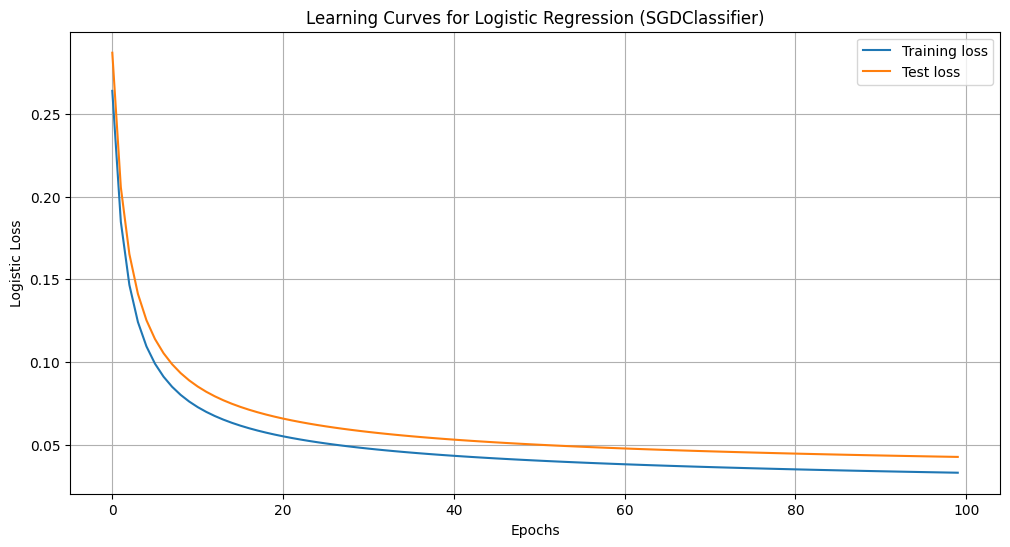

In [21]:
# Set up the SGDClassifier to mimic logistic regression
sgd_log_reg = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, penalty=None, max_iter=1, random_state=42)

# Prepare lists to store the loss values for each epoch
train_loss = []
test_loss = []

# We will perform 100 training epochs
n_epochs = 100

# Conduct the training process
for epoch in range(n_epochs):
    # Use partial_fit to update the model with the training data
    sgd_log_reg.partial_fit(X_train, y_train, classes=np.unique(y_train))

    # Calculate the logistic loss (log loss) for training data
    y_train_pred_prob = sgd_log_reg.predict_proba(X_train)[:, 1]
    train_loss.append(log_loss(y_train, y_train_pred_prob))

    # Calculate the logistic loss (log loss) for test data
    y_test_pred_prob = sgd_log_reg.predict_proba(X_test)[:, 1]
    test_loss.append(log_loss(y_test, y_test_pred_prob))

# Now, let's plot the learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Test loss')
plt.title('Learning Curves for Logistic Regression (SGDClassifier)')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Define a function to calculate metrics to avoid repetition
def calculate_classification_metrics(y_true, y_pred, y_pred_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_prob)
    return accuracy, precision, recall, f1, auc_roc

# Calculate metrics for standalone logistic regression
log_reg_pred = log_reg.predict(X_test)
log_reg_metrics = calculate_classification_metrics(y_test, log_reg_pred, y_pred_prob)

# Calculate metrics for AdaBoost model (we already have accuracy, so we'll just calculate the others)
ada_metrics = calculate_classification_metrics(y_test, y_pred_ada, y_pred_prob_ada)

# Calculate metrics for SGDClassifier
sgd_pred = sgd_log_reg.predict(X_test)
sgd_y_pred_prob = sgd_log_reg.predict_proba(X_test)[:, 1]
sgd_metrics = calculate_classification_metrics(y_test, sgd_pred, sgd_y_pred_prob)

# Combine metrics into a DataFrame for easier comparison
metrics_df = pd.DataFrame({
    'Logistic Regression': log_reg_metrics,
    'AdaBoost': ada_metrics,
    'SGDClassifier': sgd_metrics
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

metrics_df


,Logistic Regression,AdaBoost,SGDClassifier
Accuracy,0.978182,0.978182,0.981818
Precision,0.968992,0.968992,0.976562
Recall,0.984252,0.984252,0.984252
F1 Score,0.976562,0.976562,0.980392
AUC-ROC,0.999468,0.998617,0.999574
